In [47]:
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

from scipy import signal
from matplotlib import cm

import itertools
from sklearn.cluster import KMeans

In [14]:
# Path directory

def get_mseed_data(data_path):
   
    mseed_files = []

    if 'lunar' in data_path:
        categories = os.listdir(data_path)
        # Remove .DS_Store file if it exists
        if '.DS_Store' in categories:
            categories.remove('.DS_Store')

        for category in categories:
            path = data_path + category + '/'
            files = [f for f in os.listdir(path) if f.endswith('.mseed')]
            for f in files:
                mseed_files.append(path + f)
    
    else:
        files = [f for f in os.listdir(data_path) if f.endswith('.mseed')]
        for f in files:
            mseed_files.append(data_path + f)

    return mseed_files

moon_test_path = './data/lunar/test/data/'
mars_test_path = './data/mars/test/data/'
moon_data = get_mseed_data(moon_test_path)
mars_data = get_mseed_data(mars_test_path)

In [24]:
file = moon_data[0]

st = read(file)
tr = st.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data

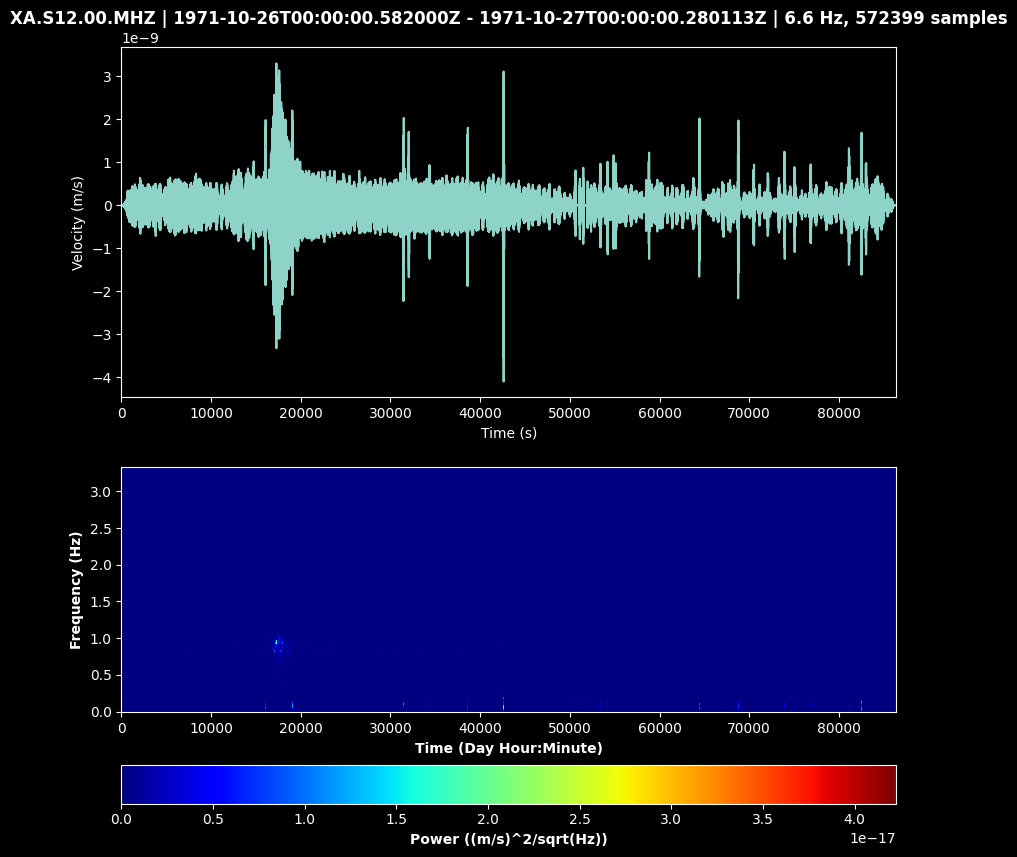

In [29]:
def plot_spectrogram(st, arrival=None):
    tr = st.traces[0]
    tr_times = tr.times()
    tr_data = tr.data

    f, t, sxx = signal.spectrogram(tr_data, tr.stats.sampling_rate)

    vmax = sxx.max()
    vmin = sxx.min()

    fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,10))

    ax1.plot(tr_times,tr_data)
    ax1.set_xlim([min(tr_times),max(tr_times)])
    ax1.set_ylabel('Velocity (m/s)')
    ax1.set_xlabel('Time (s)')
    ax1.set_title(f'{st[0]}', fontweight='bold')

    vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmin=vmin, vmax=vmax)
    ax2.set_xlim([min(tr_times),max(tr_times)])
    ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
    ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
    
    if arrival is not None:
        ax1.axvline(x = arrival, color='red',label='Rel. Arrival')
        ax2.axvline(x=arrival, c='red')

    cbar = plt.colorbar(vals, orientation='horizontal')
    cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

    plt.show()

file1 = moon_data[0]
st1 = read(file1)

plot_spectrogram(st1)

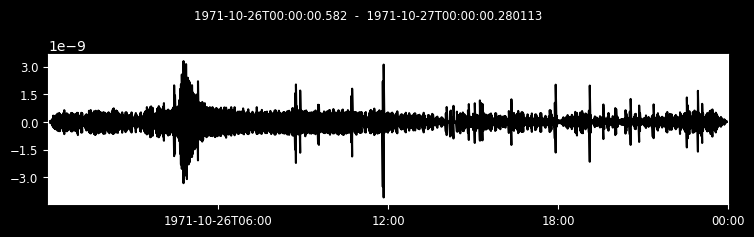

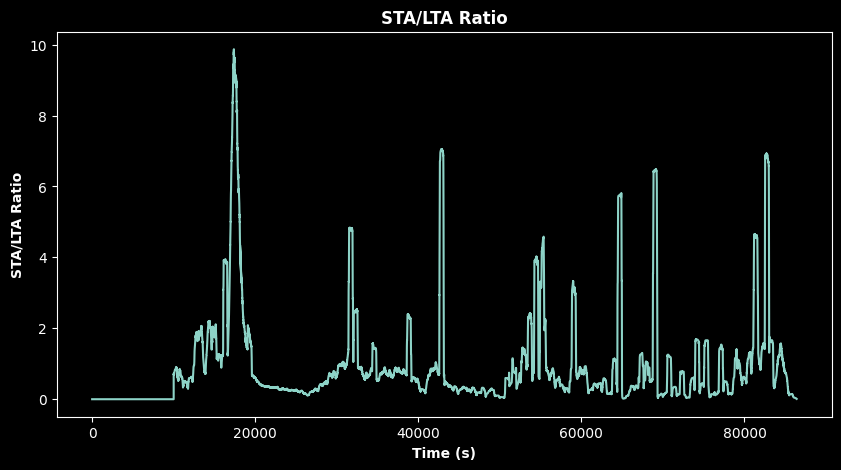

In [41]:
from obspy.signal.trigger import classic_sta_lta

def sta_lta(st, sta, lta):
    tr = st.traces[0]
    df = tr.stats.sampling_rate

    cft = classic_sta_lta(tr.data, int(sta * df), int(lta * df))

    return cft

def plot_sta_lta(st, sta, lta, arrival=None):

    ctf = sta_lta(st, sta, lta)
    tr_times = st.traces[0].times()

    fig, ax = plt.subplots(1,1,figsize=(10,5))
    ax.plot(tr_times, ctf)
    ax.set_xlabel('Time (s)', fontweight='bold')
    ax.set_ylabel('STA/LTA Ratio', fontweight='bold')
    ax.set_title('STA/LTA Ratio', fontweight='bold')

    if arrival is not None:
        ax.axvline(x = arrival, color='red',label='Rel. Arrival')

    plt.show()

sta = 500
lta = 10000

st1.plot()

plot_sta_lta(st1, sta, lta)

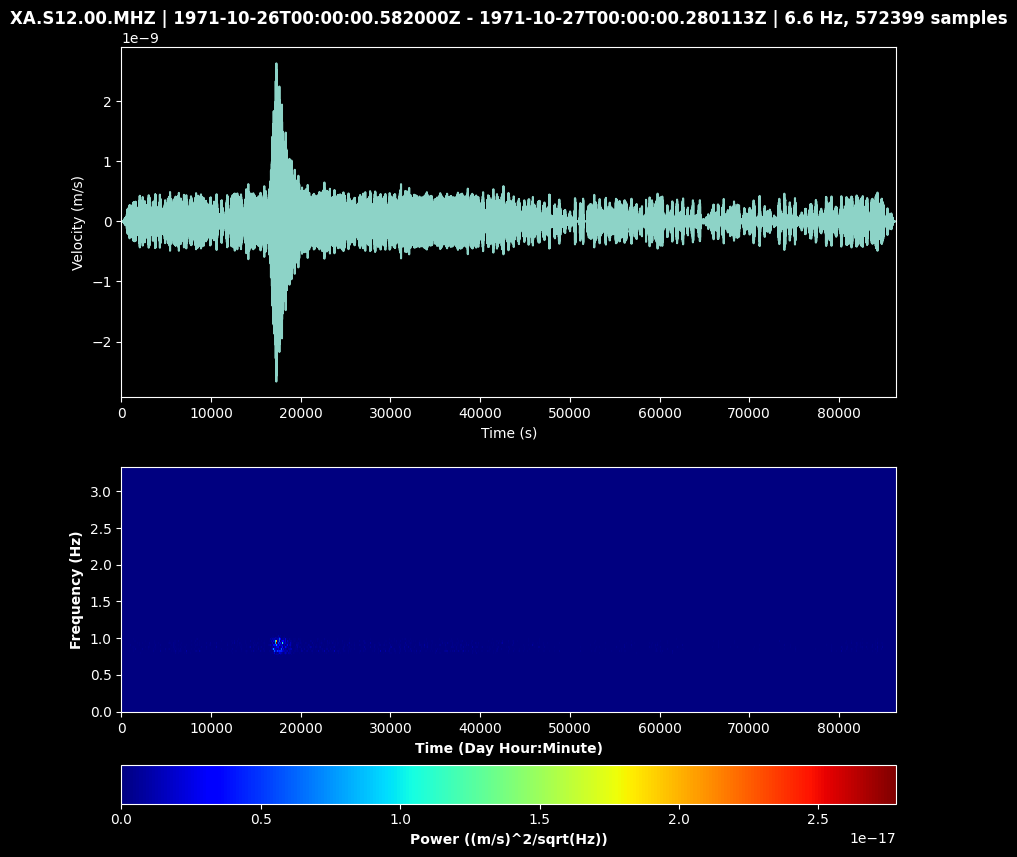

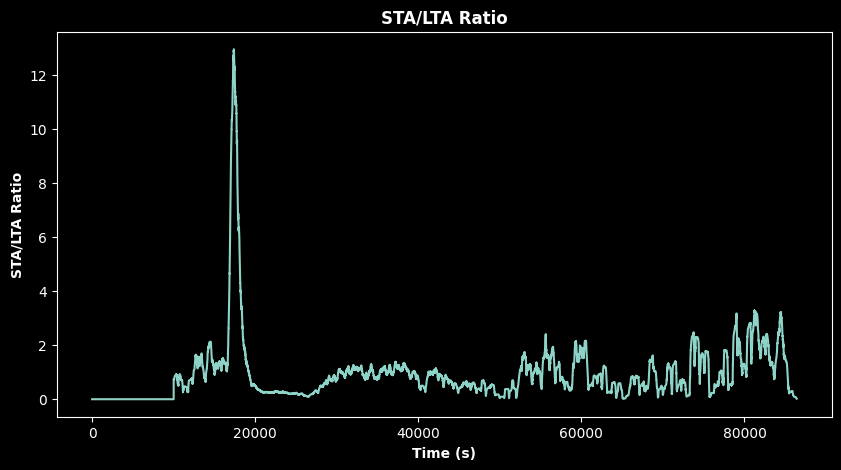

In [45]:
st_filt = st1.copy()
st_filt.filter('bandpass', freqmin=0.8, freqmax=1)

plot_spectrogram(st_filt)

plot_sta_lta(st_filt, sta, lta)

In [75]:
def find_clusters(hf_points, _min_dist = 2000):

    X = np.array(hf_points).reshape(-1, 1)  

    initial_n_clusters = 5 
    kmeans = KMeans(n_clusters=initial_n_clusters)
    kmeans.fit(X)

    centers = kmeans.cluster_centers_

    def filter_centroids(centroids, min_distance):
        filtered_centroids = []
        
        for centroid in centroids:
            if all(np.linalg.norm(centroid - other) >= min_distance for other in filtered_centroids):
                filtered_centroids.append(centroid)
        
        return np.array(filtered_centroids)

    filtered_centroids = filter_centroids(centers, _min_dist)

    return filtered_centroids



def seismic_centers_detect(st, _target=None, _STA=120, _LTA=600, _high_freq_thresh=0.05, _power_thresh=0.4, display=True):
    

    tr = st.traces[0]
    tr_times = tr.times()
    tr_data = tr.data
    tr_sampling_rate = tr.stats.sampling_rate

    act_quake_cat = _target

    fp, t, sxx = signal.spectrogram(tr_data, tr_sampling_rate, nperseg=256, noverlap=128, scaling='density')
    vmax = sxx.max()
    vmin = sxx.min()

    # Sampling frequency of our trace
    df = tr_sampling_rate

    sta_len = _STA
    lta_len = _LTA

    cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))


    if display:
        # Plot characteristic function
        fig, (ax, ax1 ,ax2) = plt.subplots(3, 1, figsize=(12, 8))

        ax.plot(tr_times,tr_data)
        ax.set_xlim([min(tr_times),max(tr_times)])
        ax.set_ylabel('Velocity (m/s)')

        ax.set_title('Filtered')

        # Plot characteristic function
        ax1.plot(tr_times, cft)
        ax1.set_xlim([min(tr_times), max(tr_times)])
        ax1.set_ylabel('Characteristic function')
        
        #ax1.legend()

        ## Plot spectrogram
        vals = ax2.pcolormesh(t, fp, sxx, cmap=cm.jet, vmin = vmin, vmax=vmax)

        ax2.set_xlim([min(tr_times), max(tr_times)])
        ax2.set_xlabel(f'Time (s)', fontweight='bold')
        ax2.set_ylabel('Frequency (Hz)')
        
        if _target:
            ax.axvline(x=act_quake_cat, c='red')
            ax1.axvline(x=act_quake_cat, c='red')
            ax2.axvline(x=act_quake_cat, c='red', linewidth=1)


    # Normalize fp and sxx
    fp = (fp - np.min(fp)) / (np.max(fp) - np.min(fp))
    sxx = (sxx - np.min(sxx)) / (np.max(sxx) - np.min(sxx))  

    high_freq_mask = fp >= _high_freq_thresh  # Mask for high frequencies
    high_power_mask = sxx > _power_thresh    # Mask for sections with high power
    # Combined mask for high-frequency and high-power regions
    combined_mask = np.logical_and(high_freq_mask[:, None], high_power_mask)
    # Extract high-frequency sections
    high_freq_sections = []
    for i in range(sxx.shape[1]):  # Iterate over time steps
        high_freqs_at_t = fp[combined_mask[:, i]]  # Extract frequencies for time step i
        if len(high_freqs_at_t) > 0:
            high_freq_sections.append((t[i], high_freqs_at_t))

    if len(high_freq_sections) > 0:
        hf_points = [row[0] for row in high_freq_sections]
        centers = find_clusters(hf_points)
        swd_centers = list(itertools.chain.from_iterable(centers))

        if display:
            for v in swd_centers:
                ax2.axvline(x=v, c='yellow', linewidth=1)
                ax.axvline(x=v-2500, c='blue', linewidth=4)
                ax.axvline(x=min((v+6500),(tr_times[-1]-100)), c='blue', linewidth=4)

    return swd_centers

swd_centers = seismic_centers_detect(st_filt, _target=None, _STA=120, _LTA=600, _high_freq_thresh=0.05, _power_thresh=0.4, display=False)

swd_centers

[np.float64(46253.88679245283)]

In [65]:
for elem in moon_data[:5]:
    st = read(elem)
    st_filt = st.copy()
    st_filt.filter('bandpass', freqmin=0.8, freqmax=1)
    swd_centers = seismic_centers_detect(st_filt, _target=None, _STA=120, _LTA=600, _high_freq_thresh=0.05, _power_thresh=0.4)

['./data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1971-10-26HR00_evid00133.mseed',
 './data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1974-10-02HR00_evid00572.mseed',
 './data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1972-11-19HR00_evid00335.mseed',
 './data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-03-14HR00_evid00018.mseed',
 './data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1974-03-14HR00_evid00506.mseed',
 './data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1971-10-06HR00_evid00125.mseed',
 './data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1973-04-23HR00_evid00399.mseed',
 './data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1971-01-03HR00_evid00057.mseed',
 './data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1971-06-11HR00_evid00096.mseed',
 './data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1972-02-28HR00_evid00192.mseed',
 './data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-05-24HR00_evid00028.mseed',
 './data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed',
 './